In [78]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import pickle

In [79]:
class Layer(object):

    def forwardPass(self, x,train) :
        pass
    
    def backwardPass(self, grad_input) :
        pass

class ParamLayer(Layer):

    def update(self, learning_rate) :
        pass

In [80]:
class LinearLayer(ParamLayer):
    
    def __init__(self,input_dim,output_dim,regularization,reg_rate=0.01):
        self.weights = np.random.normal(0.0, 0.1,size=input_dim * output_dim).reshape( input_dim,output_dim)
        self.weights = self.weights.astype('float64')
        self.biases = np.zeros((1, output_dim)).astype('float64')
        self.x = np.zeros(0)
        self.grad_biases = np.zeros(0)
        self.grad_weights = np.zeros(0)
        self.regularization = regularization
        self.reg_rate = reg_rate
        self.optimizer = Adam()
        
    def forwardPass(self,x,train = True):
        self.x = x  ## x is a input_dim,1 vector 
        return np.dot(x,self.weights) + self.biases  ## returns out_dim,1 vector
    
    def backwardPass(self,grad_input):
        self.grad_weights = np.dot(self.x.T,grad_input)
        self.grad_biases = np.sum(grad_input, axis=0, keepdims=True)
        return np.dot(grad_input,self.weights.T)
    
    def update(self, learning_rate):
        
        if self.regularization==None:
            grad_weights = self.grad_weights
        elif self.regularization == 'L1':
            grad_weights = self.grad_weights + self.reg_rate*np.sign(self.weights)
        elif self.regularization == 'L2':
            grad_weights = self.grad_weights + self.reg_rate*self.weights  
        self.weights,self.biases = self.optimizer.update(self.weights,grad_weights,self.biases,self.grad_biases)
        return self.weights,self.biases

In [156]:
class SoftmaxLayer(Layer):

    def __init__(self):
        self.next_x = np.zeros(0)

    def forwardPass(self, x,train = True):
        e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return e_x / np.sum(e_x, axis=-1, keepdims=True)

    def backwardPass(self, grad_input):
        y = self.forwardPass(grad_input)
        return y*(1-y)

In [157]:
class SigmoidLayer(Layer):

    def __init__(self):
        self.next_x = np.zeros(0)

    def forwardPass(self, x,train = True) :
        self.next_x = 1. / (1. + np.exp(-x))
        return self.next_x

    def backwardPass(self, grad_input):
        return (self.next_x * (1 - self.next_x)) * grad_input

In [158]:
import math
class ReLU(Layer):
    def __init__(self):
        self.next_x = np.zeros(0)

    def forwardPass(self, x,train = True) :
        self.next_x = np.where(x >= 0, x, 0)
        return self.next_x

    def backwardPass(self, grad_input):
        return np.where(grad_input >= 0, 1, 0)

In [159]:
class CrossEntropyLoss(Layer):

    def __init__(self, y):
        self.eps = 1e-3
        self.y = np.clip(y, self.eps, 1-self.eps)
        self.p = np.zeros(0)

    def forwardPass(self, x,train = True):
        self.p = np.clip(x, self.eps, 1.0 - self.eps)
        return -(self.y * np.log(self.p) + (1-self.y) * np.log(1 - self.p))

    def backwardPass(self, grad_input):
        error = (self.p - self.y) / (self.p - self.p ** 2)
        return error * grad_input

In [160]:
class MSELayer(Layer):

    def __init__(self, y):
        self.y = y
        self.x = np.zeros(0)

    def forward(self, x, train = True) :
        self.x = x
        return np.square(x - self.y)

    def backward(self, grad_input):
        return -2 * (self.y - self.x) * grad_input

In [161]:
class BatchNormLayer(ParamLayer):

    def __init__(self, dims) :
        self.gamma = np.ones((1, dims), dtype= 'float64')
        self.bias = np.zeros((1, dims), dtype= 'float64')
        self.eps = 1e-3

        # forward params
        self.var_x = np.zeros(0)
        self.stddev_x = np.zeros(0)
        self.x_minus_mean = np.zeros(0)
        self.standard_x = np.zeros(0)
        self.num_examples = 0
        self.mean_x = np.zeros(0)

        # backward params
        self.gamma_grad = np.zeros(0)
        self.beta_grad = np.zeros(0)
        self.optimizer = Adam()

    def forwardPass(self, x, train=True) :
        self.num_examples = x.shape[0]
        #print(f"in forward pass {self.num_examples}")
        if train:
            self.mean_x = np.mean(x, axis=0, keepdims=True)
            self.var_x = np.var(x , axis=0, keepdims=True)
        else:
            self.mean_x = self.mean_x.copy()
            self.var_x = self.var_x.copy()

        self.var_x += self.eps
        self.stddev_x = np.sqrt(self.var_x)
        self.xmu = x - self.mean_x
        self.standard_x = self.xmu / self.stddev_x
        return self.gamma * self.standard_x + self.bias

    def backwardPass(self, grad_input) :
        
        standard_grad = grad_input * self.gamma

        var_grad = np.sum(standard_grad * self.xmu * -0.5 * self.var_x ** (-3/2),
                          axis=0, keepdims=True)
        stddev_inv = 1 / self.stddev_x
        aux_xmu = 2 * self.xmu / self.num_examples

        mean_grad = (np.sum(standard_grad * -stddev_inv, axis=0,
                            keepdims=True) +
                            var_grad * np.sum(-aux_xmu, axis=0,
                            keepdims=True))

        self.gamma_grad = np.sum(grad_input * self.standard_x, axis=0,
                                 keepdims=True)
        self.bias_grad = np.sum(grad_input, axis=0, keepdims=True)
        return standard_grad * stddev_inv + var_grad * aux_xmu + mean_grad / self.num_examples
               

    def update(self, learning_rate):
        
        #self.gamma -= learning_rate * self.gamma_grad
        #self.bias -= learning_rate * self.bias_grad
        self.gamma,self.bias = self.optimizer.update(self.gamma,self.gamma_grad,self.bias,self.bias_grad)

In [162]:
class Dropout(Layer):
    
    def __init__(self,keep_prob):
        
        self.keep_prob = keep_prob
        
    def forwardPass(self,x,train):
        if train:
            self.mask = np.random.rand(x.shape[0],x.shape[1])
            self.mask = self.mask < self.keep_prob
            x = np.multiply(x,self.mask)
            x = x/self.keep_prob
        
        return x
    
    def backwardPass(self,grad_input):

        return grad_input*self.mask

In [163]:
class StochasticGradientDescent():
    def __init__(self, learning_rate=0.001, momentum=0):
        self.learning_rate = learning_rate 
        self.momentum = momentum
        self.w_updt = None
        self.b_updt = None
    def update(self, w, grad_wrt_w,b,grad_wrt_b):
        if self.w_updt is None:
            self.w_updt = np.zeros(np.shape(w))
        if self.b_updt is None:
            self.b_updt = np.zeros(np.shape(b))
        self.w_updt = self.momentum * self.w_updt + self.learning_rate * grad_wrt_w
        self.b_updt = self.momentum * self.b_updt + self.learning_rate * grad_wrt_b
        return w - self.w_updt, b - self.b_updt

In [164]:
class Adam():
    
    def __init__(self, learning_rate= 3e-4, b1=0.9, b2=0.999):
        self.learning_rate = learning_rate
        self.eps = 1e-8
        self.m_w = None
        self.v_w = None
        self.m_b = None
        self.v_b = None
        # Decay rates
        self.b1 = b1
        self.b2 = b2

    def update(self, w, grad_wrt_w,b,grad_wrt_b):
        # If not initialized
        if self.m_w is None:
            self.m_w = np.zeros(np.shape(grad_wrt_w))
            self.v_w = np.zeros(np.shape(grad_wrt_w))
        if self.m_b is None:
            self.m_b = np.zeros(np.shape(grad_wrt_b))
            self.v_b = np.zeros(np.shape(grad_wrt_b))
        
        self.m_w = self.b1 * self.m_w + (1 - self.b1) * grad_wrt_w
        self.v_w = self.b2 * self.v_w + (1 - self.b2) * np.power(grad_wrt_w, 2)

        self.m_b = self.b1 * self.m_b + (1 - self.b1) * grad_wrt_b
        self.v_b = self.b2 * self.v_b + (1 - self.b2) * np.power(grad_wrt_b, 2)
        
        m_w_hat = self.m_w / (1 - self.b1)
        v_w_hat = self.v_w / (1 - self.b2)
        self.w_updt = self.learning_rate * m_w_hat / (np.sqrt(v_w_hat) + self.eps)
        
        m_b_hat = self.m_b / (1 - self.b1)
        v_b_hat = self.v_b / (1 - self.b2)

        self.b_updt = self.learning_rate * m_b_hat / (np.sqrt(v_b_hat) + self.eps)
        

        return w - self.w_updt,b-self.b_updt

In [171]:
class NeuralNetwork:

    def __init__(self, layers):
        self.layers = layers
        self.loss_layer = None
    
    def backward_propagation(self, output) :
        grad_input = self.loss_layer.backwardPass(np.ones_like(output)) 
        for layer_index in range(len(self.layers)-1, -1, -1):
            grad_input = self.layers[layer_index].backwardPass(grad_input)

    def update_params(self, learning_rate) :
        for layer_index in range(len(self.layers)):
            layer = self.layers[layer_index]
            if isinstance(layer, ParamLayer):
                layer.update(learning_rate)

    def evaluate_model(self, test_x, 
                       test_y):
        self.loss_layer = CrossEntropyLoss(test_y)
        #self.loss_layer = MSELayer(test_y)
        y_pred = self.predict(test_x)
        y_pred_labels = np.argmax(y_pred, axis=1)
        y_labels = np.argmax(test_y, axis=1)
        loss = self.loss_layer.forwardPass(y_pred)
        accuracy = float(np.sum(y_labels == y_pred_labels) / test_x.shape[0])
        return float(np.mean(loss)),y_pred_labels,accuracy

    def fit(self, x_train, y_train,
            learning_rate, steps,
            batch_size, x_test,
            y_test) :
        
        num_examples = x_train.shape[0]
        num_batches = math.ceil(num_examples/batch_size)
        n_epochs = steps//num_batches
        training_metrics = np.zeros((n_epochs,2))  # loss, accuracy
        validation_metrics = np.zeros((n_epochs,2))
        random_index = np.linspace(0, num_examples-1, num_examples).astype(int)
        for epoch in tqdm(range(n_epochs)):
            
            np.random.shuffle(random_index)
            x_train = x_train[random_index]
            y_train = y_train[random_index]
            for index_batch in range(0, num_examples, batch_size):
                mini_batch_x = x_train[index_batch: index_batch + batch_size]
                mini_batch_y = y_train[index_batch: index_batch + batch_size]
                self.loss_layer = CrossEntropyLoss(mini_batch_y)
                #self.loss_layer = MSELayer(mini_batch_y)
                y_pred = self.predict(mini_batch_x,train = True)
                self.loss_layer.forwardPass(y_pred)
                self.backward_propagation(y_pred)
                self.update_params(learning_rate)

            tr_loss,tr_pred,tr_accuracy = self.evaluate_model(x_train, y_train)
            val_loss,val_pred,val_accuracy = self.evaluate_model(x_test,y_test)
            if epoch%50==0 : 
                print(tr_pred)
                print(tr_loss,tr_accuracy,val_loss,val_accuracy)
            training_metrics[epoch,0] = tr_loss
            training_metrics[epoch,1] = tr_accuracy
            validation_metrics[epoch,0] = val_loss
            validation_metrics[epoch,1] = val_accuracy

        return training_metrics,validation_metrics

    def predict(self, x_test,train = False) :
        for layer in self.layers:
            x_test = layer.forwardPass(x_test,train)
        return x_test

In [ ]:
class Q1DataLoader():
    
    def __init__(self):
        self.data = np.load('../Assignment 1/data/pneumoniamnist.npz')
    
    def train_test_split(self):
        
        x_train = self.data['train_images'].reshape(self.data['train_images'].shape[0],-1).astype("float32")
        x_test = self.data['test_images'].reshape(self.data['test_images'].shape[0],-1).astype("float32")
        x_val = self.data['val_images'].reshape(self.data['val_images'].shape[0],-1).astype("float32")
        y_train = self.data['train_labels'].reshape((-1,))
        y_test = self.data['test_labels'].reshape((-1,))
        y_val = self.data['val_labels'].reshape((-1,))
        
        return x_train,y_train,x_test,y_test,x_val,y_val
    
    def one_hot(self,y):
        
        one_hot_y = np.zeros((y.size, y.max()+1)).astype("float32")
        one_hot_y[np.arange(y.size), y] = 1

        return one_hot_y 
    
    def get_metrics(self,pred,actual):
        
        n_correct_preds = 0
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(actual.shape[0]):
            if pred[i] == actual[i]:
                if actual[i]==1:
                    tp += 1
                else:
                    tn += 1
            else:
                if actual[i]==1:
                    fn += 1
                else:
                    fp += 1

        accuracy = (tp+tn)/(tp+fp+tn+fn)
        if tp+fn==0:
            recall= 0 
        else:
            recall = tp/(tp+fn)
        if tp+fp==0:
            precision = 0
        else:   
            precision = tp/(tp+fp)
        if recall==0 and precision==0:
            F1 = 0 
        else:
            F1 = 2*recall*precision/(recall+precision)
        if tn+fp==0:
            specificity = 0
        else:
            specificity = tn/(tn+fp)
        AUC = (recall + specificity)/2

        return accuracy,F1,AUC

In [ ]:
class Q2DataLoader():
    
    def __init__(self):
        self.data = np.load('../Assignment 1/data/bloodmnist.npz')
    
    def train_test_split(self):
        
        x_train = self.data['train_images'].reshape(self.data['train_images'].shape[0],-1).astype("float32")
        x_test = self.data['test_images'].reshape(self.data['test_images'].shape[0],-1).astype("float32")
        x_val = self.data['val_images'].reshape(self.data['val_images'].shape[0],-1).astype("float32")
        y_train = self.data['train_labels'].reshape((-1,))
        y_test = self.data['test_labels'].reshape((-1,))
        y_val = self.data['val_labels'].reshape((-1,))
    
        return x_train,y_train,x_test,y_test,x_val,y_val
    
    
    def get_metrics(self,pred,actual):
        
        n_correct_preds = 0
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(actual.shape[0]):
            if pred[i] == actual[i]:
                if actual[i]==1:
                    tp += 1
                else:
                    tn += 1
            else:
                if actual[i]==1:
                    fn += 1
                else:
                    fp += 1

        accuracy = (tp+tn)/(tp+fp+tn+fn)
        if tp+fn==0:
            recall= 0 
        else:
            recall = tp/(tp+fn)
        if tp+fp==0:
            precision = 0
        else:   
            precision = tp/(tp+fp)
        if recall==0 and precision==0:
            F1 = 0 
        else:
            F1 = 2*recall*precision/(recall+precision)
        if tn+fp == 0:
            specificity = 0
        else:
            specificity = tn/(tn+fp)
        AUC = (recall + specificity)/2

        return accuracy,F1,AUC

In [ ]:
class Q4_DataLoader():
    
    def __init__(self):
        
        self.phoneme = {}
        phoneme_list = ["bcl","dcl","gcl","pcl","tck","kcl","dcl","tcl","b","d","g","p","t","k","dx","q","jh","ch","s","sh","z","zh","f","th","v","dh","m","n","ng","em","en","eng","nx","l","r","w","y","hh","hv","el","iy","ih","eh","ey","ae","aa","aw","ay","ah","ao","oy","ow","uh","uw","ux","er","ax","ix","axr","ax-h","pau","epi","h#"]
        phonemlist_length = 63
        #create key value dictionary
        for ph in phoneme_list: 
            if('a' in ph or 'e' in ph or 'i' in ph or 'o' in ph or 'u' in ph):
                self.phoneme[ph] = 0                                                ##phoneme is vowel
            else:
                self.phoneme[ph] = 1
    
    def get_max_feature_len(self,x):
        
        max_len = 0
        n=x.__len__()
        for i in range(n):
            max_len = max(max_len,x[i].__len__())
        return max_len
    
    def add_padding(self,x,max_len):
    
        x_train = []
        n = x.__len__()
        for i in range(n):
            m=x[i].__len__()
            temp=np.zeros(max_len)
            if(m>max_len):
                temp=x[i][:max_len]
            else:
                temp[:m]=x[i]

            x_train.append(temp)
        return x_train

    def get_x_and_y(self,file_path):
    
        x = []
        y = []
        count = 0
        for folder in os.listdir(file_path):
            
            path = file_path + folder + "/"
            temp_name = ""
            for files in os.listdir(path):
                name = files.split(".")[0]
                if name != temp_name:
                    temp_name = name
                wav_file = path + name + ".WAV"
                phn_file = path + name + ".PHN"

                data, sampling_freq = librosa.load(wav_file,sr=None, mono=True,offset=0.0,duration=None)
                data=data.tolist()

                file_obj = open(phn_file, 'r')
                phonem_data = file_obj.readlines()
                n=np.shape(phonem_data)[0]

                for i in range(n):
                    
                    lower,upper,ph=phonem_data[i].split(" ")
                    lower = int(lower)
                    upper = int(upper)
                    ph = ph.replace("\n", "")
                    temp = data[lower:upper]
                    temp = np.array(temp)
                    count += 1
                    mfccs = librosa.feature.mfcc(temp, sr=sampling_freq)
                    mfccs = mfccs.flatten()
                    temp = mfccs.tolist()
                    x.append(temp)
                    y.append(self.phoneme[ph])
                    
        return x,y
    
    def preprocessing_audio(self,path):
  
        path_test  = path + "test/DR1/"
        path_train = path + "train/DR1/"
        x_train,y_train = self.get_x_and_y(path_train)         
        x_test,y_test = self.get_x_and_y(path_test)
        max_len = self.get_max_feature_len(x_train)
        max_len = max(max_len,self.get_max_feature_len(x_test))
        x_train = self.add_padding(x_train,max_len)
        x_test = self.add_padding(x_test,max_len)

        return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)
    
    def get_metrics(self,pred,actual):
        n_correct_preds = 0
        tp = 0
        fp = 0
        tn = 0
        fn = 0
        for i in range(actual.shape[0]):
            if pred[i] == actual[i]:
                if actual[i]==1:
                    tp += 1
                else:
                    tn += 1
            else:
                if actual[i]==1:
                    fn += 1
                else:
                    fp += 1
        
        return tp/actual.shape[0],fp/actual.shape[0],tn/actual.shape[0],fn/actual.shape[0]


In [173]:

def one_hot(y):
        
    one_hot_y = np.zeros((y.size, y.max()+1)).astype("float32")
    one_hot_y[np.arange(y.size), y] = 1

    return one_hot_y 

if __name__=='__main__':
    
    
    
    dataset = Q2DataLoader()
    x_train,y_train,x_test,y_test,x_val,y_val = dataset.train_test_split()
    learning_rate = 1e-3
    batch_size = 100
    neurons = 100
    steps = 10000
    
    '''
    with open('Q4.pkl', 'rb') as infile:
        result = pickle.load(infile)
    
    
    x_train,y_train,x_test,y_test = result'''
    
    
    y_train_hot = one_hot(y_train)
    y_test_hot = one_hot(y_test)
    y_val_hot = one_hot(y_val)
    print(x_train.shape,y_train_hot.shape)
    
    ## single Linear Layer networks 
    
    model_baseline = NeuralNetwork([LinearLayer(x_train.shape[1],neurons,None), SigmoidLayer(),
                                    LinearLayer(neurons, y_train_hot.shape[1],None),SigmoidLayer()])
    baseline_tr_metrics,baseline_val_metrics = model_baseline.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    baseline_tr_loss = baseline_tr_metrics[:,0]
    baseline_tr_accuracy = baseline_tr_metrics[:,1]
    baseline_val_loss = baseline_val_metrics[:,0]
    baseline_val_accuracy = baseline_val_metrics[:,1]
    baseline_pred = model_baseline.evaluate_model(x_test,y_test_hot)[1]
    
    print(f'baseline metrics on test data= {dataset.get_metrics(baseline_pred,y_test)}')
    
    model_batchNorm = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                BatchNormLayer(neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    batchNorm_tr_metrics,batchNorm_val_metrics = model_batchNorm.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    batchNorm_tr_loss = batchNorm_tr_metrics[:,0]
    batchNorm_tr_accuracy = batchNorm_tr_metrics[:,1]
    batchNorm_val_loss = batchNorm_val_metrics[:,0]
    batchNorm_val_accuracy = batchNorm_val_metrics[:,1]
    batchNorm_pred = model_batchNorm.evaluate_model(x_test,y_test_hot)[1]

    
    print(f'batchNorm metrics = {dataset.get_metrics(batchNorm_pred,y_test)}')
    
    model_dropout = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                SigmoidLayer(),
                                Dropout(0.8),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    dropout_tr_metrics, dropout_val_metrics= model_dropout.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    dropout_tr_loss = dropout_tr_metrics[:,0]
    dropout_tr_accuracy = dropout_tr_metrics[:,1]
    dropout_val_loss = dropout_val_metrics[:,0]
    dropout_val_accuracy = dropout_val_metrics[:,1]
    dropout_pred = model_dropout.evaluate_model(x_test,y_test_hot)[1]

    
    print(f'dropout metrics = {dataset.get_metrics(dropout_pred,y_test)}')
    
    model_L1 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    L1_tr_metrics,L1_val_metrics = model_L1.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    L1_tr_loss = L1_tr_metrics[:,0]
    L1_tr_accuracy = L1_tr_metrics[:,1]
    L1_val_loss = L1_val_metrics[:,0]
    L1_val_accuracy = L1_val_metrics[:,1]
    L1_pred = model_L1.evaluate_model(x_test,y_test_hot)[1]
    
    print(f'L1 metrics = {dataset.get_metrics(L1_pred,y_test)}')
    
    model_L2 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    

    L2_tr_metrics,L2_val_metrics = model_L2.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    L2_tr_loss = L2_tr_metrics[:,0]
    L2_tr_accuracy = L2_tr_metrics[:,1]
    L2_val_loss = L2_val_metrics[:,0]
    L2_val_accuracy = L2_val_metrics[:,1]
    L2_pred = model_L2.evaluate_model(x_test,y_test_hot)[1]
    
    print(f'L2 metrics = {dataset.get_metrics(L2_pred,y_test)}')
    
    ##baseline_accuracy_test = model_baseline.evaluate_model(x_test,y_test)[:,1]
    
    ##print("Training Model w/ Batch Norm")
    ##baseline_accuracy_test = model_baseline.evaluate_model(x_test,y_test)[:,1]
    ##print(f"Baseline accuracy on Test Data{bn_accuracy}")
    

(11959, 2352) (11959, 8)


  0%|                                                                                           | 0/83 [00:00<?, ?it/s]C:\Users\Asus\AppData\Local\Temp/ipykernel_17376/2614723586.py:7: RuntimeWarning: overflow encountered in exp
  self.next_x = 1. / (1. + np.exp(-x))
  1%|█                                                                                  | 1/83 [00:04<05:36,  4.10s/it]

[6 6 6 ... 6 6 6]
0.3730899406916936 0.19499958190484154 0.3731108476996422 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [03:25<02:35,  4.87s/it]

[6 6 6 ... 6 6 6]
0.36739639879620334 0.19491596287314994 0.36743334333381855 0.19467991815258695


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [06:37<00:00,  4.79s/it]


baseline metrics on test data= (0.19467991815258695, 0, 0.11905613156953879)


  1%|█                                                                                  | 1/83 [00:04<06:20,  4.64s/it]

[6 0 7 ... 6 6 6]
0.28476456240651454 0.646709591102935 0.28686430756785986 0.631102016954107


 61%|██████████████████████████████████████████████████▍                               | 51/83 [03:56<02:26,  4.59s/it]

[3 6 0 ... 1 1 3]
0.13510563005538279 0.8299188895392592 0.15038163714055855 0.7848582285881321


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [06:21<00:00,  4.59s/it]


batchNorm metrics = (0.8079508915521777, 0.648850881881347, 0.8719699105268466)


  1%|█                                                                                  | 1/83 [00:03<05:07,  3.75s/it]

[6 6 6 ... 6 6 6]
0.3735008297369983 0.1948323438414583 0.37349836467806335 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [03:04<01:53,  3.55s/it]

[6 6 6 ... 6 6 6]
0.36741854189628204 0.1948323438414583 0.3674436257365829 0.19467991815258695


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [05:52<00:00,  4.25s/it]


dropout metrics = (0.19467991815258695, 0, 0.11905613156953879)


  1%|█                                                                                  | 1/83 [00:03<04:50,  3.54s/it]

[6 6 6 ... 6 6 6]
0.3682518799124445 0.1948323438414583 0.3682829308924206 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [02:56<01:52,  3.52s/it]

[6 6 6 ... 6 6 6]
0.3673903600455101 0.19491596287314994 0.36742580361834 0.19467991815258695


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [05:35<00:00,  4.04s/it]


L1 metrics = (0.19467991815258695, 0, 0.11905613156953879)


  1%|█                                                                                  | 1/83 [00:03<04:52,  3.57s/it]

[6 6 6 ... 6 6 6]
0.3697040411222812 0.1948323438414583 0.36972249243384525 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [04:13<03:57,  7.42s/it]

[1 1 1 ... 1 1 1]
0.3453257860307749 0.31900660590350366 0.3450364563462139 0.3177433498976907


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [09:51<00:00,  7.13s/it]


L2 metrics = (0.2844197603040047, 0, 0.173936360386128)


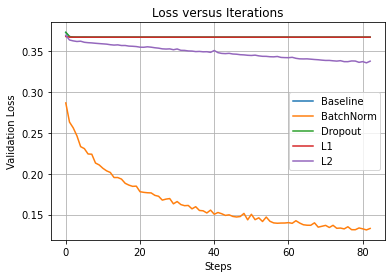

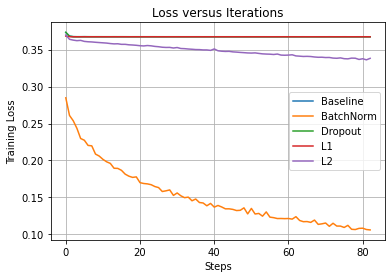

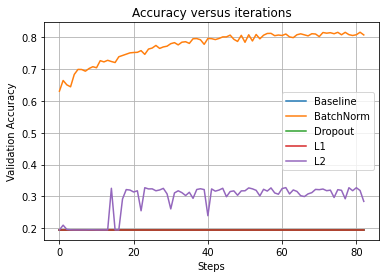

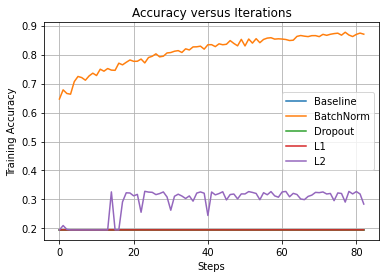

  0%|                                                                                           | 0/83 [00:00<?, ?it/s]C:\Users\Asus\AppData\Local\Temp/ipykernel_17376/2614723586.py:7: RuntimeWarning: overflow encountered in exp
  self.next_x = 1. / (1. + np.exp(-x))
  1%|█                                                                                  | 1/83 [00:07<10:18,  7.55s/it]

[6 6 6 ... 6 6 6]
0.3676122816709519 0.1948323438414583 0.3676464094539431 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [06:39<04:04,  7.65s/it]

[6 6 6 ... 6 6 6]
0.32347597741823236 0.32979346099172174 0.32331460321011773 0.3291435252850044


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [12:32<00:00,  9.06s/it]


In [174]:
    num_batches = math.ceil(x_train.shape[0] / batch_size)
    steps_axis = np.linspace(1, steps/num_batches, len(baseline_val_loss)//10+1)
    steps_axis = steps_axis.astype("int")

    plt.plot(baseline_val_loss, label="Baseline")
    plt.plot(batchNorm_val_loss, label="BatchNorm")
    plt.plot(dropout_val_loss, label="Dropout")
    plt.plot(L1_val_loss,label = "L1")
    plt.plot(L2_val_loss,label = "L2")
    plt.ylabel("Validation Loss")
    plt.xlabel("Steps")
    plt.title("Loss versus Iterations")
    locs = np.linspace(0, len(baseline_val_loss)-1, len(baseline_val_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_tr_loss, label="Baseline")
    plt.plot(batchNorm_tr_loss, label="BatchNorm")
    plt.plot(dropout_tr_loss, label="Dropout")
    plt.plot(L1_tr_loss,label = "L1")
    plt.plot(L2_tr_loss,label = "L2")
    plt.ylabel("Training Loss")
    plt.xlabel("Steps")
    plt.title("Loss versus Iterations")
    locs = np.linspace(0, len(baseline_tr_loss)-1, len(baseline_tr_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_val_accuracy, label="Baseline")
    plt.plot(batchNorm_val_accuracy, label="BatchNorm")
    plt.plot(dropout_val_accuracy, label="Dropout")
    plt.plot(L1_val_accuracy,label = "L1")
    plt.plot(L2_val_accuracy,label = "L2")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Steps")
    plt.title("Accuracy versus iterations")
    locs = np.linspace(0, len(baseline_val_loss)-1, len(baseline_val_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid() 
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_tr_accuracy, label="Baseline")
    plt.plot(batchNorm_tr_accuracy, label="BatchNorm")
    plt.plot(dropout_tr_accuracy, label="Dropout")
    plt.plot(L1_tr_accuracy,label = "L1")
    plt.plot(L2_tr_accuracy,label = "L2")
    plt.ylabel("Training Accuracy")
    plt.xlabel("Steps")
    plt.title("Accuracy versus Iterations")
    locs = np.linspace(0, len(baseline_tr_accuracy)-1, len(baseline_tr_accuracy)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    
    ## 2 layer neural Networks 
    
    model_baseline =NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons,None),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    baseline_tr_metrics,baseline_val_metrics = model_baseline.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    baseline_tr_loss = baseline_tr_metrics[:,0]
    baseline_tr_accuracy = baseline_tr_metrics[:,1]
    baseline_val_loss = baseline_val_metrics[:,0]
    baseline_val_accuracy = baseline_val_metrics[:,1]
    

C:\Users\Asus\AppData\Local\Temp/ipykernel_17376/2614723586.py:7: RuntimeWarning: overflow encountered in exp
  self.next_x = 1. / (1. + np.exp(-x))


baseline metrics on test data = (0.3273896521484946, 0, 0.20021451555237754)


  1%|█                                                                                  | 1/83 [00:10<13:41, 10.02s/it]

[2 6 7 ... 3 3 6]
0.2893342544190666 0.6411071159795969 0.2914502413431011 0.6296404560070155


 61%|██████████████████████████████████████████████████▍                               | 51/83 [08:00<05:39, 10.60s/it]

[1 2 7 ... 3 6 3]
0.10059951402147914 0.881595451124676 0.1255990453169157 0.8246126863490207


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [13:03<00:00,  9.44s/it]


batchNorm metrics = (0.8582285881321251, 0.7094068304373877, 0.8933793533364502)


  1%|█                                                                                  | 1/83 [00:07<10:39,  7.79s/it]

[6 6 6 ... 6 6 6]
0.36842754380112164 0.1948323438414583 0.3684537904423458 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [06:51<04:24,  8.26s/it]

[7 7 7 ... 7 7 6]
0.34397385900669913 0.2827159461493436 0.3440603223420411 0.28120432622040337


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [12:49<00:00,  9.27s/it]


dropout metrics = (0.2987430575855013, 0, 0.18269574544154452)


  1%|█                                                                                  | 1/83 [00:10<14:00, 10.24s/it]

[6 6 6 ... 6 6 6]
0.3684186101158932 0.1948323438414583 0.36840742664830173 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [08:25<05:00,  9.39s/it]

[1 1 7 ... 1 7 1]
0.31637613027284944 0.31909022493519523 0.3165711261299885 0.3203741596024554


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [13:28<00:00,  9.74s/it]


L1 metrics = (0.29406606255480855, 0, 0.17983553807651054)


  1%|█                                                                                  | 1/83 [00:09<12:48,  9.37s/it]

[6 6 6 ... 6 6 6]
0.3676438113980244 0.1948323438414583 0.3676768172701808 0.19467991815258695


 61%|██████████████████████████████████████████████████▍                               | 51/83 [08:01<05:15,  9.86s/it]

[6 6 6 ... 6 6 6]
0.3674568958060835 0.1948323438414583 0.36748860274817136 0.19467991815258695


100%|██████████████████████████████████████████████████████████████████████████████████| 83/83 [13:00<00:00,  9.41s/it]


L2 metrics = (0.19467991815258695, 0, 0.11905613156953879)


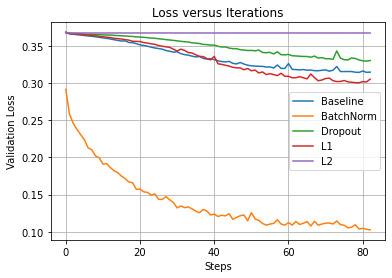

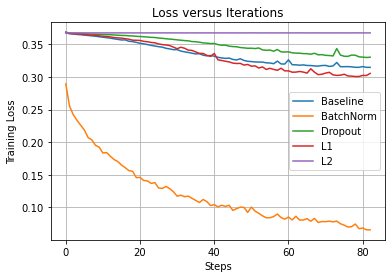

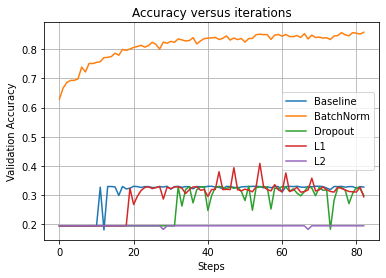

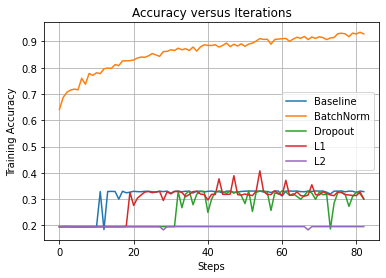

In [175]:
    baseline_pred = model_baseline.evaluate_model(x_test,y_test_hot)[1]
    
    print(f'baseline metrics on test data = {dataset.get_metrics(baseline_pred,y_test)}')
    
    model_batchNorm = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                BatchNormLayer(neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons,None),
                                BatchNormLayer(neurons),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    batchNorm_tr_metrics,batchNorm_val_metrics = model_batchNorm.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    batchNorm_tr_loss = batchNorm_tr_metrics[:,0]
    batchNorm_tr_accuracy = batchNorm_tr_metrics[:,1]
    batchNorm_val_loss = batchNorm_val_metrics[:,0]
    batchNorm_val_accuracy = batchNorm_val_metrics[:,1]
    batchNorm_pred = model_batchNorm.evaluate_model(x_test,y_test_hot)[1]

    
    print(f'batchNorm metrics = {dataset.get_metrics(batchNorm_pred,y_test)}')
    
    model_dropout = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,None),
                                SigmoidLayer(),
                                Dropout(0.8),
                                LinearLayer(neurons, neurons,None),
                                SigmoidLayer(),
                                Dropout(0.6),
                                LinearLayer(neurons, y_train_hot.shape[1],None),
                                SigmoidLayer()])
    dropout_tr_metrics, dropout_val_metrics= model_dropout.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    dropout_tr_loss = dropout_tr_metrics[:,0]
    dropout_tr_accuracy = dropout_tr_metrics[:,1]
    dropout_val_loss = dropout_val_metrics[:,0]
    dropout_val_accuracy = dropout_val_metrics[:,1]
    dropout_pred = model_dropout.evaluate_model(x_test,y_test_hot)[1]

    
    print(f'dropout metrics = {dataset.get_metrics(dropout_pred,y_test)}')
    
    model_L1 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,'L1'),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons,'L1'),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],'L1'),
                                SigmoidLayer()])
    L1_tr_metrics,L1_val_metrics = model_L1.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    L1_tr_loss = L1_tr_metrics[:,0]
    L1_tr_accuracy = L1_tr_metrics[:,1]
    L1_val_loss = L1_val_metrics[:,0]
    L1_val_accuracy = L1_val_metrics[:,1]
    L1_pred = model_L1.evaluate_model(x_test,y_test_hot)[1]
    
    
    print(f'L1 metrics = {dataset.get_metrics(L1_pred,y_test)}')
    
    model_L2 = NeuralNetwork([LinearLayer(x_train.shape[1], neurons,'L2'),
                                SigmoidLayer(),
                                LinearLayer(neurons, neurons,'L2'),
                                SigmoidLayer(),
                                LinearLayer(neurons, y_train_hot.shape[1],'L2'),
                                SigmoidLayer()])
    

    L2_tr_metrics,L2_val_metrics = model_L2.fit(x_train, y_train_hot, steps=steps,
                                           learning_rate=learning_rate,
                                           batch_size=batch_size,
                                           x_test = x_test,y_test = y_test_hot)
    L2_tr_loss = L2_tr_metrics[:,0]
    L2_tr_accuracy = L2_tr_metrics[:,1]
    L2_val_loss = L2_val_metrics[:,0]
    L2_val_accuracy = L2_val_metrics[:,1]
    L2_pred = model_L2.evaluate_model(x_test,y_test_hot)[1]
    
    print(f'L2 metrics = {dataset.get_metrics(L2_pred,y_test)}')
    
    
    ##baseline_accuracy_test = model_baseline.evaluate_model(x_test,y_test)[:,1]
    
    ##print("Training Model w/ Batch Norm")
    ##baseline_accuracy_test = model_baseline.evaluate_model(x_test,y_test)[:,1]
    ##print(f"Baseline accuracy on Test Data{bn_accuracy}")
    num_batches = math.ceil(x_train.shape[0] / batch_size)
    steps_axis = np.linspace(1, steps/num_batches, len(baseline_val_loss)//10+1)
    steps_axis = steps_axis.astype("int")

    plt.plot(baseline_val_loss, label="Baseline")
    plt.plot(batchNorm_val_loss, label="BatchNorm")
    plt.plot(dropout_val_loss, label="Dropout")
    plt.plot(L1_val_loss,label = "L1")
    plt.plot(L2_val_loss,label = "L2")
    plt.ylabel("Validation Loss")
    plt.xlabel("Steps")
    plt.title("Loss versus Iterations")
    locs = np.linspace(0, len(baseline_val_loss)-1, len(baseline_val_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_tr_loss, label="Baseline")
    plt.plot(batchNorm_tr_loss, label="BatchNorm")
    plt.plot(dropout_tr_loss, label="Dropout")
    plt.plot(L1_tr_loss,label = "L1")
    plt.plot(L2_tr_loss,label = "L2")
    plt.ylabel("Training Loss")
    plt.xlabel("Steps")
    plt.title("Loss versus Iterations")
    locs = np.linspace(0, len(baseline_tr_loss)-1, len(baseline_tr_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_val_accuracy, label="Baseline")
    plt.plot(batchNorm_val_accuracy, label="BatchNorm")
    plt.plot(dropout_val_accuracy, label="Dropout")
    plt.plot(L1_val_accuracy,label = "L1")
    plt.plot(L2_val_accuracy,label = "L2")
    plt.ylabel("Validation Accuracy")
    plt.xlabel("Steps")
    plt.title("Accuracy versus iterations")
    locs = np.linspace(0, len(baseline_val_loss)-1, len(baseline_val_loss)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid() 
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(baseline_tr_accuracy, label="Baseline")
    plt.plot(batchNorm_tr_accuracy, label="BatchNorm")
    plt.plot(dropout_tr_accuracy, label="Dropout")
    plt.plot(L1_tr_accuracy,label = "L1")
    plt.plot(L2_tr_accuracy,label = "L2")
    plt.ylabel("Training Accuracy")
    plt.xlabel("Steps")
    plt.title("Accuracy versus Iterations")
    locs = np.linspace(0, len(baseline_tr_accuracy)-1, len(baseline_tr_accuracy)//10+1)
    #plt.xticks(locs, [str(x)+"k" for x in steps_axis])
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()
    ## 3 layers 
    
    
